## Anomaly Detection- Mahalanobis Distance

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import feather
import os
os.chdir("/Users/adesai/mcadoo-failures-master/")
import glob
import random
import datetime
from sklearn.preprocessing import MinMaxScaler
import scipy as sp

In [2]:
failures = pd.read_csv("failures.csv", index_col=0)
failures.head()

,Site,ID,Distance.to.turbine.south,Distance.to.turbine.north,Distance.to.terrain.feature.south,Distance.to.terrain.feature.north,Component.Manufacturer,Oil.Grease.Type,Failure,Individual.Damaged.Components,Starting.Date,Shutdown.Date,Operating.Hours.Before.Failure,Wallclock.Minutes.Before.Failure
1,McAdoo,1,35,35,1670,750,Moventas,Castrol A 320,no,na,7/2/08,NaN,24,NaN
2,McAdoo,2,35,35,1720,1020,Winergy,Castrol A 320,yes,HSS Bearing A,7/2/08,2/20/12,11,1912380.0
3,McAdoo,3,35,35,1700,1050,Winergy,Castrol A 320,no,na,7/2/08,NaN,24,NaN
4,McAdoo,4,35,36,2450,1160,Moventas,Castrol A 320,yes,HSS Bearing A,7/2/08,2/10/12,10,1897980.0
5,McAdoo,4,35,36,2450,1160,Moventas,Castrol X 320,yes,HSS Bearing A,2/10/12,4/29/13,2,639300.0


In [3]:
#winergy data
healthy = [3, 5, 6, 24, 26, 30, 31, 34, 35, 36, 37, 53, 55, 59, 63, 64, 69, 73, 76, 77, 78, 81, 83, 85,\
          85, 86, 92, 93, 94, 95, 97]

hss_a = [2, 29, 65, 70, 84]
hss_b = [19, 38, 65, 82]
ims_a = [65]
ims_b = [11, 48, 65, 66, 79, 80]

failed = list(np.unique(hss_a + hss_b + ims_a + ims_b))

In [4]:
len(healthy)

31

In [5]:
len(failed)

13

In [6]:
# getting various turbines raw data having running state from running folder 

def rms(data):
    rms = np.sqrt(np.sum([i**2 for i in data]))/len(data)
    return rms

def kurtosis(data):
    norm_data = data - np.mean(data)
    if sum(norm_data) == 0:
        return np.nan
    ku = np.mean(norm_data**4)/np.mean(norm_data**2)**2
    return ku


feats_1 = ['power', 'rotor_speed', 'gearbox_oil_temperature', 'gearbox_bearing_temperature', 'nacelle_temperature']
feats_3 = ['failure']

agg_dict = {i:['mean', np.std, rms, kurtosis] for i in feats_1}

def value(data):
    return data.value_counts().index[0]
agg_dict.update({i:[value] for i in feats_3})


def prep_df(turbine_ids):
    df = pd.DataFrame()

    for i in turbine_ids:
        temp_df = feather.read_dataframe(glob.glob("Datafeathers/running/*_" + str(i) + "_*.feather")[0])
        temp_df.time = pd.to_datetime(temp_df.time)
        temp_df["Date"] = temp_df.time.dt.date
        temp_df.drop(['wind_direction_10_sec', 'wind_direction_1_sec', 'stateFault',\
                      'ambient_temperature', 'wind_speed'], axis = 1, inplace = True)
        temp_df['failure'] = 0
                
        shutdown_date = pd.to_datetime(failures['Shutdown.Date'][failures.ID == i].iloc[0])
        if(pd.notnull(shutdown_date)):
            temp_df.loc[(temp_df.Date <= shutdown_date) & \
                        (temp_df.Date >= (shutdown_date - datetime.timedelta(days=30))), 'failure'] = 1
        
        temp_df = temp_df[(temp_df.Date >= pd.to_datetime("2010-01-01")) &\
                         (temp_df.Date < pd.to_datetime("2014-01-01"))]
        
        df = df.append(temp_df)
    
    df = df.reset_index(drop = True)
    
    df = df.groupby(['turbine_id', 'Date']).agg(agg_dict)
    df.columns = ['_'.join(x) if isinstance(x,tuple) else x for x in df.columns.ravel()]
    df = df.reset_index()
    
    df.fillna(df.mean(), inplace = True)
    
    return df

In [7]:
len(healthy)

31

In [8]:
random.seed(30)
train_ids = random.sample(healthy, k=26)

Data to train various models

In [9]:
train_df = prep_df(train_ids)
train_df.head()

,turbine_id,Date,power_mean,power_std,power_rms,power_kurtosis,rotor_speed_mean,rotor_speed_std,rotor_speed_rms,rotor_speed_kurtosis,...,gearbox_oil_temperature_kurtosis,gearbox_bearing_temperature_mean,gearbox_bearing_temperature_std,gearbox_bearing_temperature_rms,gearbox_bearing_temperature_kurtosis,nacelle_temperature_mean,nacelle_temperature_std,nacelle_temperature_rms,nacelle_temperature_kurtosis,failure_value
0,3,2010-01-01,674.513363,500.397497,69.902067,1.628955,15.092565,4.589776,1.314199,6.181490,...,10.841549,59.600711,3.780748,4.976640,7.270238,12.106499,6.696972,1.152007,1.632289,0
1,3,2010-01-02,156.199000,187.334524,20.284203,2.604802,9.591764,5.829685,0.934490,2.119117,...,1.599664,49.311574,10.372826,4.198611,1.873471,11.441724,4.881814,1.036084,3.481327,0
2,3,2010-01-03,72.534890,82.445805,9.133051,3.803945,9.173306,4.516311,0.851490,3.259598,...,2.099597,50.482708,7.608617,4.254077,2.454057,13.621354,5.026238,1.209422,5.034011,0
3,3,2010-01-04,125.039468,251.482388,39.398831,3.281520,6.331825,7.037804,1.331406,1.697236,...,2.230750,43.443350,10.296980,6.310677,2.202140,13.746878,2.354840,1.971857,7.305402,0
4,3,2010-01-05,941.198198,540.820387,90.381506,1.757879,17.070171,2.037740,1.432544,3.869536,...,5.092369,60.314749,3.518045,5.034713,6.854889,9.031592,4.967071,0.858253,2.262455,0


In [10]:
train_df.shape

(35977, 23)

Data of failed turbines

In [11]:
failed_df = prep_df(failed)
failed_df.head()

,turbine_id,Date,power_mean,power_std,power_rms,power_kurtosis,rotor_speed_mean,rotor_speed_std,rotor_speed_rms,rotor_speed_kurtosis,...,gearbox_oil_temperature_kurtosis,gearbox_bearing_temperature_mean,gearbox_bearing_temperature_std,gearbox_bearing_temperature_rms,gearbox_bearing_temperature_kurtosis,nacelle_temperature_mean,nacelle_temperature_std,nacelle_temperature_rms,nacelle_temperature_kurtosis,failure_value
0,2,2010-01-01,677.773797,503.445437,70.271028,1.619450,15.062179,4.651560,1.313276,6.355420,...,11.140742,58.344942,3.504226,4.870779,5.707393,13.702697,4.501151,1.201514,2.498939,0
1,2,2010-01-02,297.713840,172.100470,43.238351,1.822747,13.718411,2.314453,1.752397,3.020201,...,4.091325,56.883135,2.648662,7.174243,5.731830,10.624947,4.842952,1.469107,2.009854,0
2,2,2010-01-03,72.897379,95.302648,9.976900,4.736658,8.540665,4.986558,0.823425,2.240347,...,1.773552,47.687089,7.196346,4.018608,2.063545,12.523779,3.990492,1.094996,3.664337,0
3,2,2010-01-04,214.171394,250.924840,38.458330,1.745641,8.527414,7.510733,1.326005,1.212858,...,1.168000,46.199908,12.138680,5.588345,1.166124,10.354646,2.676560,1.251216,4.160120,0
4,2,2010-01-05,948.990019,541.542664,90.975192,1.801376,17.106063,2.029494,1.435434,3.952413,...,4.794221,59.251065,2.850688,4.943260,6.113759,11.514074,2.744340,0.986200,3.542624,0


Data of 5 healthy turbines to validate model

In [12]:
test_healthy = list(set(healthy).difference(train_ids))
healthy_df = prep_df(test_healthy)

healthy_df.head()

,turbine_id,Date,power_mean,power_std,power_rms,power_kurtosis,rotor_speed_mean,rotor_speed_std,rotor_speed_rms,rotor_speed_kurtosis,...,gearbox_oil_temperature_kurtosis,gearbox_bearing_temperature_mean,gearbox_bearing_temperature_std,gearbox_bearing_temperature_rms,gearbox_bearing_temperature_kurtosis,nacelle_temperature_mean,nacelle_temperature_std,nacelle_temperature_rms,nacelle_temperature_kurtosis,failure_value
0,37,2010-01-01,666.239822,498.045664,69.232018,1.608800,15.016327,4.823278,1.313901,5.557038,...,9.470928,58.843148,3.652870,4.912970,5.151267,12.809537,5.873849,1.173630,1.746293,0
1,37,2010-01-02,156.456141,196.851352,20.909839,2.106454,9.899774,5.650948,0.949111,2.304370,...,1.628648,48.782656,8.903904,4.131919,1.808862,11.271325,4.003939,0.996393,4.829231,0
2,37,2010-01-03,21.998822,64.022537,5.623839,8.598940,3.348356,5.034545,0.502647,1.985555,...,1.654879,35.005145,12.909654,3.107855,1.702554,9.864413,3.360770,0.868120,3.509443,0
3,37,2010-01-04,-3.343621,1.098405,0.562854,5.305572,0.008474,0.005596,0.001620,1.763954,...,2.086248,15.263974,1.474769,2.455283,2.014057,4.759004,0.381510,0.764433,2.255021,0
4,37,2010-01-05,413.731970,315.706590,66.432617,2.050533,15.463350,2.218752,1.999825,1.564718,...,2.693442,57.131708,4.687253,7.339141,2.211695,13.484153,3.439897,1.780870,1.677756,0


.

### Mahalanobis Distance

In [13]:
list(train_df.columns)

['turbine_id',
 'Date',
 'power_mean',
 'power_std',
 'power_rms',
 'power_kurtosis',
 'rotor_speed_mean',
 'rotor_speed_std',
 'rotor_speed_rms',
 'rotor_speed_kurtosis',
 'gearbox_oil_temperature_mean',
 'gearbox_oil_temperature_std',
 'gearbox_oil_temperature_rms',
 'gearbox_oil_temperature_kurtosis',
 'gearbox_bearing_temperature_mean',
 'gearbox_bearing_temperature_std',
 'gearbox_bearing_temperature_rms',
 'gearbox_bearing_temperature_kurtosis',
 'nacelle_temperature_mean',
 'nacelle_temperature_std',
 'nacelle_temperature_rms',
 'nacelle_temperature_kurtosis',
 'failure_value']

In [14]:
feats = train_df.columns.drop(['Date', 'turbine_id', 'failure_value'])

In [15]:
def mahalanobis(x=None, data=None, cov=None):
    """Compute the Mahalanobis Distance between each row of x and the data  
    x    : vector or matrix of data with, say, p columns.
    data : ndarray of the distribution from which Mahalanobis distance of each observation of x is to be computed.
    cov  : covariance matrix (p x p) of the distribution. If None, will be computed from data.
    """
    x_minus_mu = x - np.mean(data)
    if not cov:
        cov = np.cov(data.values.T)
    inv_covmat = sp.linalg.inv(cov)
    left_term = np.dot(x_minus_mu, inv_covmat)
    mahal = np.dot(left_term, x_minus_mu.T)
    return mahal.diagonal()

In [16]:
failed_df['mahala'] = mahalanobis(x=failed_df[feats], data=train_df[feats])
failed_df.head()

,turbine_id,Date,power_mean,power_std,power_rms,power_kurtosis,rotor_speed_mean,rotor_speed_std,rotor_speed_rms,rotor_speed_kurtosis,...,gearbox_bearing_temperature_mean,gearbox_bearing_temperature_std,gearbox_bearing_temperature_rms,gearbox_bearing_temperature_kurtosis,nacelle_temperature_mean,nacelle_temperature_std,nacelle_temperature_rms,nacelle_temperature_kurtosis,failure_value,mahala
0,2,2010-01-01,677.773797,503.445437,70.271028,1.619450,15.062179,4.651560,1.313276,6.355420,...,58.344942,3.504226,4.870779,5.707393,13.702697,4.501151,1.201514,2.498939,0,10.971248
1,2,2010-01-02,297.713840,172.100470,43.238351,1.822747,13.718411,2.314453,1.752397,3.020201,...,56.883135,2.648662,7.174243,5.731830,10.624947,4.842952,1.469107,2.009854,0,22.140510
2,2,2010-01-03,72.897379,95.302648,9.976900,4.736658,8.540665,4.986558,0.823425,2.240347,...,47.687089,7.196346,4.018608,2.063545,12.523779,3.990492,1.094996,3.664337,0,45.694755
3,2,2010-01-04,214.171394,250.924840,38.458330,1.745641,8.527414,7.510733,1.326005,1.212858,...,46.199908,12.138680,5.588345,1.166124,10.354646,2.676560,1.251216,4.160120,0,93.821055
4,2,2010-01-05,948.990019,541.542664,90.975192,1.801376,17.106063,2.029494,1.435434,3.952413,...,59.251065,2.850688,4.943260,6.113759,11.514074,2.744340,0.986200,3.542624,0,13.957475


/Users/adesai/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


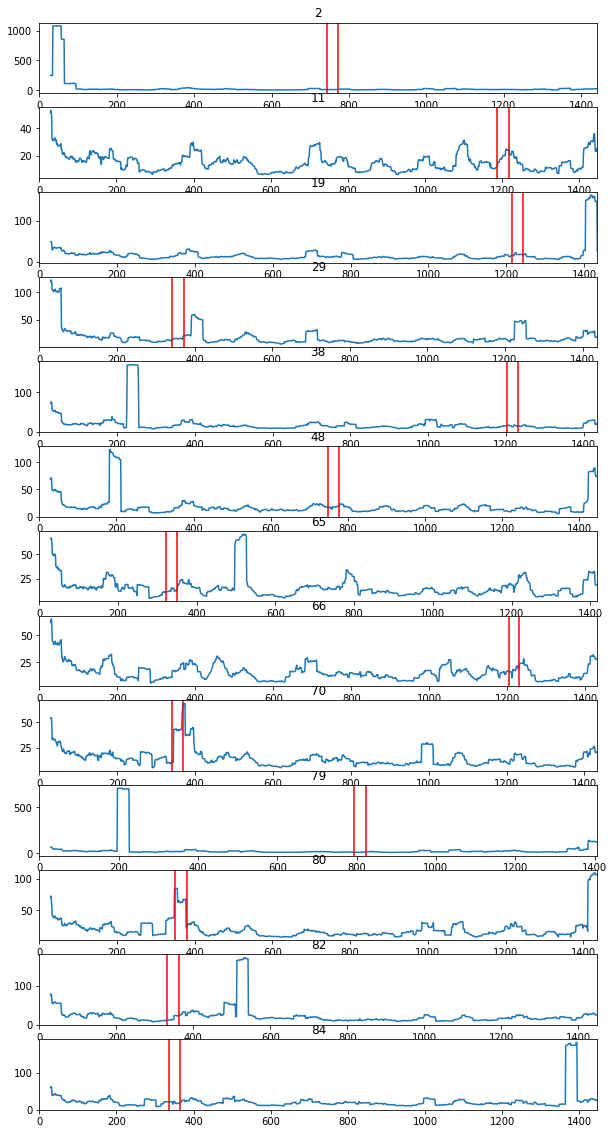

In [21]:
fig, ax = plt.subplots(figsize=(10,20), nrows=13, ncols=1)
i =0 
for key, grp in failed_df.groupby(['turbine_id']):
    grp['mahala'] = grp['mahala'].rolling(window=30).mean()
    grp = grp.reset_index()
    grp['mahala'].plot(kind='line', ax=ax[i], title = key)
    
    min_ind = grp.index[grp.failure_value == 1].min()
    max_ind = grp.index[grp.failure_value == 1].max()
    
    ax[i].axvline(x=min_ind, color = "red")
    ax[i].axvline(x=max_ind, color = "red")
    
    i = i+1

In [40]:
healthy_df['mahala'] = mahalanobis(x=healthy_df[feats], data=train_df[feats])
healthy_df.head()

,turbine_id,Date,power_mean,power_std,power_rms,power_kurtosis,rotor_speed_mean,rotor_speed_std,rotor_speed_rms,rotor_speed_kurtosis,...,gearbox_bearing_temperature_mean,gearbox_bearing_temperature_std,gearbox_bearing_temperature_rms,gearbox_bearing_temperature_kurtosis,nacelle_temperature_mean,nacelle_temperature_std,nacelle_temperature_rms,nacelle_temperature_kurtosis,failure_value,mahala
0,37,2010-01-01,666.239822,498.045664,69.232018,1.608800,15.016327,4.823278,1.313901,5.557038,...,58.843148,3.652870,4.912970,5.151267,12.809537,5.873849,1.173630,1.746293,0,13.424754
1,37,2010-01-02,156.456141,196.851352,20.909839,2.106454,9.899774,5.650948,0.949111,2.304370,...,48.782656,8.903904,4.131919,1.808862,11.271325,4.003939,0.996393,4.829231,0,51.709784
2,37,2010-01-03,21.998822,64.022537,5.623839,8.598940,3.348356,5.034545,0.502647,1.985555,...,35.005145,12.909654,3.107855,1.702554,9.864413,3.360770,0.868120,3.509443,0,202.179601
3,37,2010-01-04,-3.343621,1.098405,0.562854,5.305572,0.008474,0.005596,0.001620,1.763954,...,15.263974,1.474769,2.455283,2.014057,4.759004,0.381510,0.764433,2.255021,0,488.842452
4,37,2010-01-05,413.731970,315.706590,66.432617,2.050533,15.463350,2.218752,1.999825,1.564718,...,57.131708,4.687253,7.339141,2.211695,13.484153,3.439897,1.780870,1.677756,0,27.182836


/Users/adesai/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


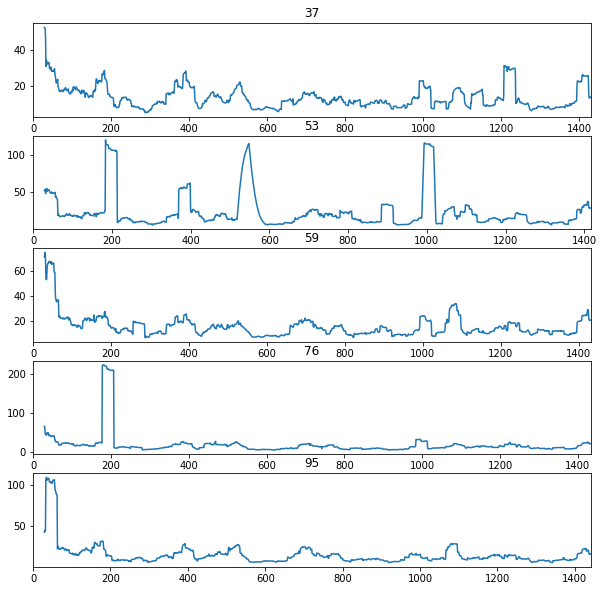

In [41]:
fig, ax = plt.subplots(figsize=(10,10), nrows=5, ncols=1)
i =0 
for key, grp in healthy_df.groupby(['turbine_id']):
    grp['mahala'] = grp['mahala'].rolling(window=30).mean()
    grp = grp.reset_index()
    grp['mahala'].plot(kind='line', ax=ax[i], title = key)
    
    i = i+1